# Visualizing Air Quality in Budapest with Folium
## Introduction
The **goal of this notebook** is to apply new skills learned from the [Geospatial Analysis course](https://www.kaggle.com/learn/geospatial-analysis) to visualize the air quality in Budapest, Hungary. I live in this city, so I thought it would be interesting to compare its districts in this regard. 

I have compiled the dataset for this project from a [website](https://aqicn.org/city/budapest/) that is measuring air pollution across the world. There are measurements for 5 main parameters over the years 2016-2019: co, no2, o3, pm10, so2 (read further about these pollutants in the "Pollutants" section [here](https://en.wikipedia.org/wiki/Air_pollution)). 

In Budapest there are 12 measuring stations, in my analysis I had to remove one of them (situated in the 5th district) as it is fairly new and doesn't have measurements for the whole period of research. 

The geodata about Budapest districts is taken from OSMNX (a Python package for downloading administrative boundary shapes and street networks from OpenStreetMap) using [geocoding](https://www.kaggle.com/alexisbcook/manipulating-geospatial-data).

During my research I have created the following 4 maps of Budapest districts:
1. A simple map showing district borders and location of 11 measuring stations with the option to choose from a range of map tiles;
2. A choropleth map showing the Air Quality Index (AQI) value for each district (a maximum among median values of the 5 measured parameters);
3. A timeslider choropleth map demonstrating how the AQI value for each district changed over the researched period (2016-2019);
4. A choropleth map displaying 5 parameters of the aggregate AQI using feature group and layer control.

The logbook of this project can be found [here](https://docs.google.com/spreadsheets/d/1N_3xASxg3NRPEUMzZn5oDMCpE0OkMCAhTfPZsqVewjc/edit?usp=sharing). It includes the following tabs:

- Time spent on the project
- Ideas for this project
- Useful information for the project (links and info I found about Geospatial Analysis)
- AQI (data sources)
- Possible future improvements
- Lessons learned from the project

The dataset for this project can be found [here](https://www.kaggle.com/tatianasnwrt/geo-bud-districts).

The GitHub repository of this project is [here](https://github.com/TatianaSnauwaert/BP_Air_Quality_Folium).

In [1]:
# Import necessary libraries
import geopandas as gdp
import numpy as np
import pandas as pd

import osmnx as ox
%matplotlib inline
print("OSMNX version:", ox.__version__)

import folium
from folium import Choropleth, Marker
from folium.plugins import TimeSliderChoropleth, Fullscreen, MiniMap, LocateControl

from PIL import Image

print("Folium version:", folium.__version__)

OSMNX version: 0.10
Folium version: 0.10.1


## 1. Data collection and preparation
### 1.1 Geodata for district borders
First, we'll use the geocoding technique to create a data frame containing the Geometry column. It contains all of the geometric objects that are displayed when we call the plot() method. While this column can contain a variety of different datatypes, each entry will typically be a Point, LineString, or Polygon.

For geocoding we need a list of strings - names of objects we want to retrieve geodata for, so we create a list of district names. Then we can use the ox.gdf_from_places(places) to get data directly from OSMNX. I reached the limit quite quickly by just reloading this notebook's page, so I saved the data into a geo dataframe and uploaded it to my [dataset](https://www.kaggle.com/tatianasnwrt/geo-bud-districts). 

In [2]:
# places = ['1st district, Budapest, Hungary', '2nd district, Budapest, Hungary', '3rd district, Budapest, Hungary',
#           '4th district, Budapest, Hungary', '5th district, Budapest, Hungary', '6th district, Budapest, Hungary',
#           '7th district, Budapest, Hungary', '8th district, Budapest, Hungary', '9th district, Budapest, Hungary',
#           '10th district, Budapest, Hungary', '11th district, Budapest, Hungary', '12th district, Budapest, Hungary',
#           '13th district, Budapest, Hungary', '14th district, Budapest, Hungary', '15th district, Budapest, Hungary',
#           '16th district, Budapest, Hungary', '17th district, Budapest, Hungary', '18th district, Budapest, Hungary', 
#           '19th district, Budapest, Hungary', '20th district, Budapest, Hungary', '21st district, Budapest, Hungary',
#           '22nd district, Budapest, Hungary', '23rd district, Budapest, Hungary']

# gdf_districts = ox.gdf_from_places(places)

We read directly from the dataset and add a column called "district_code" to make it easier to use further.

In [3]:
gdf_districts = gdp.read_file("../input/geo-bud-districts/Gdf_districts/Gdf_districts/gdf_districts.shp")

for i in range(len(gdf_districts)):
    gdf_districts.loc[i,'district_code'] = i + 1
    
gdf_districts.head()

place_name  bbox_north  bbox_south  \
0  1st district, Budapest, Central Hungary, Hungary   47.508081   47.485671   
1  2nd district, Budapest, Central Hungary, Hungary   47.578906   47.506060   
2  3rd district, Budapest, Central Hungary, Hungary   47.610094   47.526869   
3  4th district, Budapest, Central Hungary, Hungary   47.613147   47.542325   
4  5th district, Budapest, Central Hungary, Hungary   47.514747   47.485786   

   bbox_east  bbox_west                                           geometry  \
0  19.051307  19.023778  POLYGON ((19.02378 47.49568, 19.02380 47.49619...   
1  19.042713  18.925106  POLYGON ((18.92511 47.54414, 18.92919 47.54560...   
2  19.076146  18.976838  POLYGON ((18.97684 47.57484, 18.97751 47.57575...   
3  19.123463  19.067197  POLYGON ((19.06720 47.56314, 19.06741 47.56360...   
4  19.061780  19.042022  POLYGON ((19.04202 47.51471, 19.04332 47.51475...   

   district_code  
0            1.0  
1            2.0  
2            3.0  
3            4.0  
4            5.0

### 1.2 Location of air quality measuring stations

We are going to use data from 11 measuring stations in Budapest while there are 23 districts. To resolve this issue, we will find the closest station to the center of each district. For that, we need to find the centroid of each polygon (center of each district) and it will be a POINT object with longitude and latitude coordinates.

In [4]:
gdf_districts["centroid"] = gdf_districts.geometry.centroid
gdf_districts.head()

place_name  bbox_north  bbox_south  \
0  1st district, Budapest, Central Hungary, Hungary   47.508081   47.485671   
1  2nd district, Budapest, Central Hungary, Hungary   47.578906   47.506060   
2  3rd district, Budapest, Central Hungary, Hungary   47.610094   47.526869   
3  4th district, Budapest, Central Hungary, Hungary   47.613147   47.542325   
4  5th district, Budapest, Central Hungary, Hungary   47.514747   47.485786   

   bbox_east  bbox_west                                           geometry  \
0  19.051307  19.023778  POLYGON ((19.02378 47.49568, 19.02380 47.49619...   
1  19.042713  18.925106  POLYGON ((18.92511 47.54414, 18.92919 47.54560...   
2  19.076146  18.976838  POLYGON ((18.97684 47.57484, 18.97751 47.57575...   
3  19.123463  19.067197  POLYGON ((19.06720 47.56314, 19.06741 47.56360...   
4  19.061780  19.042022  POLYGON ((19.04202 47.51471, 19.04332 47.51475...   

   district_code                   centroid  
0            1.0  POINT (19.03576 47.49697)  
1            2.0  POINT (18.97954 47.54218)  
2            3.0  POINT (19.03354 47.56996)  
3            4.0  POINT (19.09580 47.57962)  
4            5.0  POINT (19.05068 47.50035)

Next, we find each station's coordinates.
We do this manually through this source: http://levegominoseg.hu/automata

Station in district V was removed from our project as it is new and doesn't have measurements for all the researched years.

In [5]:
station_in_XVIII = [47.431369, 19.182132]
station_in_I = [47.508139, 19.027195]
station_in_VIII = [47.493856, 19.084479]
station_in_II = [47.562394, 18.961156]
station_in_IV = [47.585405, 19.114884]
station_in_XV = [47.543465, 19.146288]
station_in_XI = [47.475782, 19.041205]
station_in_XIII = [47.521744, 19.068248]
# station_in_V = [47.497555, 19.052645]
station_in_X = [47.467456, 19.155798]
station_in_XXII = [47.406248, 19.009319]
station_in_XXI = [47.404750, 19.091043]

In [6]:
list_of_stations = [station_in_XVIII, station_in_I, station_in_VIII, station_in_II, station_in_IV, 
                    station_in_XV, station_in_XI, station_in_XIII, station_in_X, station_in_XXII, station_in_XXI]

# Change places latitude and longitude as required further
for station in list_of_stations:
    station[0], station[1] = station[1], station[0]

Finally, create a geo dataframe containing the location of each station in the special "geometry" column.

In [7]:
stations_df = pd.DataFrame(list_of_stations, columns = ["latitude","longitude"])

names = ['station_in_XVIII', 'station_in_I', 'station_in_VIII', 'station_in_II', 
         'station_in_IV', 'station_in_XV', 'station_in_XI', 'station_in_XIII', 'station_in_X',
         'station_in_XXII', 'station_in_XXI']
stations_df['station_district'] = names

gdf_stations = gdp.GeoDataFrame(stations_df, geometry=gdp.points_from_xy(stations_df.latitude, stations_df.longitude))
gdf_stations.head()

latitude  longitude  station_district                   geometry
0  19.182132  47.431369  station_in_XVIII  POINT (19.18213 47.43137)
1  19.027195  47.508139      station_in_I  POINT (19.02719 47.50814)
2  19.084479  47.493856   station_in_VIII  POINT (19.08448 47.49386)
3  18.961156  47.562394     station_in_II  POINT (18.96116 47.56239)
4  19.114884  47.585405     station_in_IV  POINT (19.11488 47.58541)

Let's draw our first simple map showing district borders and location of 11 measuring stations with the option to choose from a range of map tiles. Different tiles let us highlight different aspects in our analysis.
To prevent the fact that the continents are continually repeated and the map can be panned endlessly from either side, we set a minimum zoom and set max_bounds=True.

In [8]:
# Assign the same CRS to both dataframes (EPSG 4326 that uses latitude and longitude)
gdf_stations.crs = {'init' :'epsg:4326'}
gdf_districts.crs = {'init' :'epsg:4326'}

# Initialize a map
m_stations = folium.Map(location=[47.4917,19.1102], min_zoom=2, max_bounds=True, tiles='cartodbpositron', zoom_start=11)

# Add a GeoJsonTooltip to the map to show district number when hovering the mouse over it
mykwargs = {"fields": ['district_code']} # works
# mykwargs = {"permanent": True, "fields": ['district_code']} # does not work
mytooltip = folium.GeoJsonTooltip(**mykwargs)

# Draw a simple map with district borders
folium.GeoJson(
    gdf_districts[['geometry','district_code']], 
    tooltip=mytooltip,
    style_function=lambda x: {'color':'black','fillColor':'green','weight':1},
    highlight_function=lambda x: {'weight':3,'fillColor':'yellow'}
    ).add_to(m_stations)

# Add stations to the map
for idx, row in gdf_stations.iterrows():
    Marker([row['longitude'], row['latitude']],popup=row['station_district']).add_to(m_stations)

# Add tile layers to the map
tiles = ["Stamen Toner", 'stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain', "Mapbox Bright"]
for tile in tiles:
    folium.TileLayer(tile).add_to(m_stations)

# Create a layer control
folium.LayerControl(collapsed=True).add_to(m_stations)

# Save and display the map
m_stations.save('stations_and_borders.html')
m_stations

/opt/conda/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## 2. The AQI value for each district

In this section we are going to calculate the median Air Quality Index value over the years 2016-2019 for each district based on the maximum among 5 measured parameters (co, no2, o3, pm10, so2).

I've decided to use the median index value for visualization because it shows us the situation in each district most of the time. If I'd use the mean value then I would just take an average of some extreme values over the years (probably due to some temporary issues) which is not representative of what it's like to live in a district on a daily basis.

I am taking the maximum value among the components to represent the worst air quality based on a technique that is applied when [the CAQI index](https://en.wikipedia.org/wiki/Air_quality_index#Europe) is calculated.

First, we are going to find the closet station to each district center as there are only 11 stations and as much as 23 districts in Budapest. We create a geo dataframe that contains the centers of each district.

In [9]:
gdf_centroid = gdp.GeoDataFrame(gdf_districts["district_code"], geometry=gdf_districts["centroid"])
gdf_centroid.head()

district_code                   geometry
0            1.0  POINT (19.03576 47.49697)
1            2.0  POINT (18.97954 47.54218)
2            3.0  POINT (19.03354 47.56996)
3            4.0  POINT (19.09580 47.57962)
4            5.0  POINT (19.05068 47.50035)

We have to make sure that both dataframes - stations and district centers - use the same CRS (coordinate reference system - shows how the projected points correspond to real locations on Earth) to calculate distances properly. We will change the CRS of both dataframes to EPSG 2263 because it allows us to measure distances in meters.

In [10]:
gdf_stations.crs = {'init' :'epsg:2263'}
gdf_centroid.crs = {'init' :'epsg:2263'}

We then find the closest station. For that we first calculate the distance from every station to every district center and then take the minimum of that list.

In [11]:
closest_stations = []

for district in range(len(gdf_centroid)):
    distance_list = gdf_stations.geometry.distance(gdf_centroid.iloc[district].geometry)
    closest_stations.append(gdf_stations.iloc[distance_list.idxmin()]["station_district"])
    
gdf_districts["closest_station"] = closest_stations
gdf_districts.drop(["bbox_north","bbox_south","bbox_east","bbox_west"], axis=1, inplace=True)
gdf_districts.head()

place_name  \
0  1st district, Budapest, Central Hungary, Hungary   
1  2nd district, Budapest, Central Hungary, Hungary   
2  3rd district, Budapest, Central Hungary, Hungary   
3  4th district, Budapest, Central Hungary, Hungary   
4  5th district, Budapest, Central Hungary, Hungary   

                                            geometry  district_code  \
0  POLYGON ((19.02378 47.49568, 19.02380 47.49619...            1.0   
1  POLYGON ((18.92511 47.54414, 18.92919 47.54560...            2.0   
2  POLYGON ((18.97684 47.57484, 18.97751 47.57575...            3.0   
3  POLYGON ((19.06720 47.56314, 19.06741 47.56360...            4.0   
4  POLYGON ((19.04202 47.51471, 19.04332 47.51475...            5.0   

                    centroid  closest_station  
0  POINT (19.03576 47.49697)     station_in_I  
1  POINT (18.97954 47.54218)    station_in_II  
2  POINT (19.03354 47.56996)  station_in_XIII  
3  POINT (19.09580 47.57962)    station_in_IV  
4  POINT (19.05068 47.50035)     station_in_I

Here we crete a dataframe showing an index value for each parameter per station on a (almost) daily basis. As we will 

In [12]:
AQI_raw = pd.read_csv("../input/geo-bud-districts/AQI_raw_no_st_V.csv",index_col=[0], header=[0,1],skip_blank_lines=False)

AQI_raw.columns.set_levels(['station_in_I','station_in_II',"station_in_IV",'station_in_VIII','station_in_X','station_in_XI',
                           'station_in_XIII','station_in_XV','station_in_XVIII','station_in_XXI','station_in_XXII'],level=0,inplace=True)
AQI_raw = AQI_raw.apply(pd.to_numeric,errors='coerce')
AQI_raw.head()

station_in_I                       station_in_II                  \
                   pm10    o3   no2  so2   co          pm10    o3  no2  so2   
2019-12-28         17.0  12.0  14.0  4.0  6.0          17.0  20.0  9.0  NaN   
2019-12-27         10.0  12.0   6.0  4.0  5.0           6.0  20.0  3.0  NaN   
2019-12-26         13.0  12.0   9.0  4.0  5.0           6.0  21.0  4.0  1.0   
2019-12-25         10.0  14.0   6.0  3.0  5.0           6.0  21.0  3.0  1.0   
2019-12-24         10.0  14.0   7.0  3.0  5.0           8.0  21.0  3.0  1.0   

                 ... station_in_XXI                      station_in_XXII  \
             co  ...           pm10    o3  no2  so2   co            pm10   
2019-12-28  5.0  ...           20.0   4.0  4.0  7.0  5.0            14.0   
2019-12-27  3.0  ...            5.0  10.0  1.0  6.0  2.0             5.0   
2019-12-26  3.0  ...            5.0  11.0  1.0  6.0  4.0             8.0   
2019-12-25  2.0  ...            4.0  12.0  1.0  6.0  3.0             4.0   
2019-12-24  2.0  ...            9.0   9.0  1.0  6.0  5.0             7.0   

                                 
              o3  no2  so2   co  
2019-12-28  16.0  8.0  NaN  4.0  
2019-12-27  17.0  3.0  6.0  2.0  
2019-12-26  16.0  5.0  6.0  1.0  
2019-12-25  18.0  3.0  6.0  1.0  
2019-12-24  17.0  5.0  6.0  1.0  

[5 rows x 55 columns]

As we see, we've got quite a few NaN values, so we'll first try to fill them with backward fill. It makes the replaced missing value more realistic (unless something special happend that day) as we are taking a value measured the next day. If there are still NaNs after that, we'll fill them with the median values of their columns.

In [13]:
AQI_raw = AQI_raw.bfill().fillna(AQI_raw.median())
AQI_raw.isnull().values.any()

False

In [14]:
unstacked_AQI = AQI_raw.unstack()
unstacked_AQI.index.names = ["station_in_district", "parameter", "date"]
unstacked_AQI.head()

station_in_district  parameter  date      
station_in_I         pm10       2019-12-28    17.0
                                2019-12-27    10.0
                                2019-12-26    13.0
                                2019-12-25    10.0
                                2019-12-24    10.0
dtype: float64

In [15]:
median_AQI_per_param = unstacked_AQI.groupby(["station_in_district","parameter"]).median()
median_AQI_per_param.head()

station_in_district  parameter
station_in_I          co           5.0
                     no2          19.0
                     o3           13.0
                     pm10         29.0
                     so2           2.0
dtype: float64

In [16]:
historical_AQI_per_station = median_AQI_per_param.groupby(["station_in_district"]).max()
historical_AQI_per_station.head()

station_in_district
station_in_I       29.0
station_in_II      30.0
station_in_IV      25.0
station_in_VIII    23.0
station_in_X       21.0
dtype: float64

Once we've found the historical AQI value per station, we are going to use pd.Series.map() function to assign that value to the closest district. We then make the district_id the index of the dataframe. To create a choropleth map both geodata (to draw district borders) and data (the AQI values) have to have the same index.

In [17]:
gdf_districts['AQI']=gdf_districts.closest_station.map(historical_AQI_per_station)

gdf_districts['district_id'] = ['district_I','district_II','district_III','district_IV','district_V','district_VI','district_VII',
                            'district_VIII','district_IX','district_X','district_XI','district_XII','district_XIII','district_XIV',
                            'district_XV','district_XVI','district_XVII','district_XVIII','district_XIX','district_XX','district_XXI',
                            'district_XXII','district_XXIII']
gdf_districts.set_index('district_id', inplace=True)

gdf_districts.head()

place_name  \
district_id                                                      
district_I    1st district, Budapest, Central Hungary, Hungary   
district_II   2nd district, Budapest, Central Hungary, Hungary   
district_III  3rd district, Budapest, Central Hungary, Hungary   
district_IV   4th district, Budapest, Central Hungary, Hungary   
district_V    5th district, Budapest, Central Hungary, Hungary   

                                                       geometry  \
district_id                                                       
district_I    POLYGON ((19.02378 47.49568, 19.02380 47.49619...   
district_II   POLYGON ((18.92511 47.54414, 18.92919 47.54560...   
district_III  POLYGON ((18.97684 47.57484, 18.97751 47.57575...   
district_IV   POLYGON ((19.06720 47.56314, 19.06741 47.56360...   
district_V    POLYGON ((19.04202 47.51471, 19.04332 47.51475...   

              district_code                   centroid  closest_station   AQI  
district_id                                                                    
district_I              1.0  POINT (19.03576 47.49697)     station_in_I  29.0  
district_II             2.0  POINT (18.97954 47.54218)    station_in_II  30.0  
district_III            3.0  POINT (19.03354 47.56996)  station_in_XIII  19.0  
district_IV             4.0  POINT (19.09580 47.57962)    station_in_IV  25.0  
district_V              5.0  POINT (19.05068 47.50035)     station_in_I  29.0

In [18]:
districts = gdp.GeoDataFrame(gdf_districts[['geometry','district_code']])
districts.head()

geometry  district_code
district_id                                                                   
district_I    POLYGON ((19.02378 47.49568, 19.02380 47.49619...            1.0
district_II   POLYGON ((18.92511 47.54414, 18.92919 47.54560...            2.0
district_III  POLYGON ((18.97684 47.57484, 18.97751 47.57575...            3.0
district_IV   POLYGON ((19.06720 47.56314, 19.06741 47.56360...            4.0
district_V    POLYGON ((19.04202 47.51471, 19.04332 47.51475...            5.0

In [19]:
# Initialize a map
m_choropleth_AQI = folium.Map(location=[47.4917,19.0902], min_zoom=2, max_bounds=True, tiles='cartodbpositron', zoom_start=11)

# Draw a choropleth map on it
choropleth = Choropleth(geo_data=districts.to_json(),
                        data=gdf_districts.AQI,
                        key_on="feature.id", 
                        fill_color='YlGnBu', 
                        legend_name='Air Quality Index - the max median among 5 parameters over 2016-2019',
                        highlight = True
             ).add_to(m_choropleth_AQI)

# Add a GeoJsonTooltip to the map to show district number when hovering the mouse over it
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['district_code'],labels=False)
)

# Add a fullscreen view tool to the top left (not working on Kaggle, works if saved and opened as html)
m_choropleth_AQI.add_child(Fullscreen(position='topleft', title='Full Screen', title_cancel='Exit Full Screen'))

# Add a minimap in the bottom right corner. Moving or zooming the small map affect the big one also. 
# Here just to show this functionality, no real purpose.
minimap = MiniMap(tile_layer='cartodbpositron',zoom_level_offset=-6)
m_choropleth_AQI.add_child(minimap)


# Add a LocateControl tool to the top left (not working on Kaggle, works if saved and opened as html).
# By clicking on it, it will show on the map the geolocation of the user.
LocateControl(auto_start=True).add_to(m_choropleth_AQI)

# Save and display the map
m_choropleth_AQI.save('median_AQI_per_district.html')
m_choropleth_AQI

According to the map above the best overall air quality is in the 6th, 13th, 11th and 3rd districts. The worst air quality is in the 2nd, 12th, 1st and 5th districts. The difference between the best and the worst districts is not enormous - it ranges from 19 to 30. 

According to [the aqicn.org definition](https://aqicn.org/city/budapest/), the overall air pollution level in Budapest can be described as Good (0-50) (from the image below read the Health Implications).

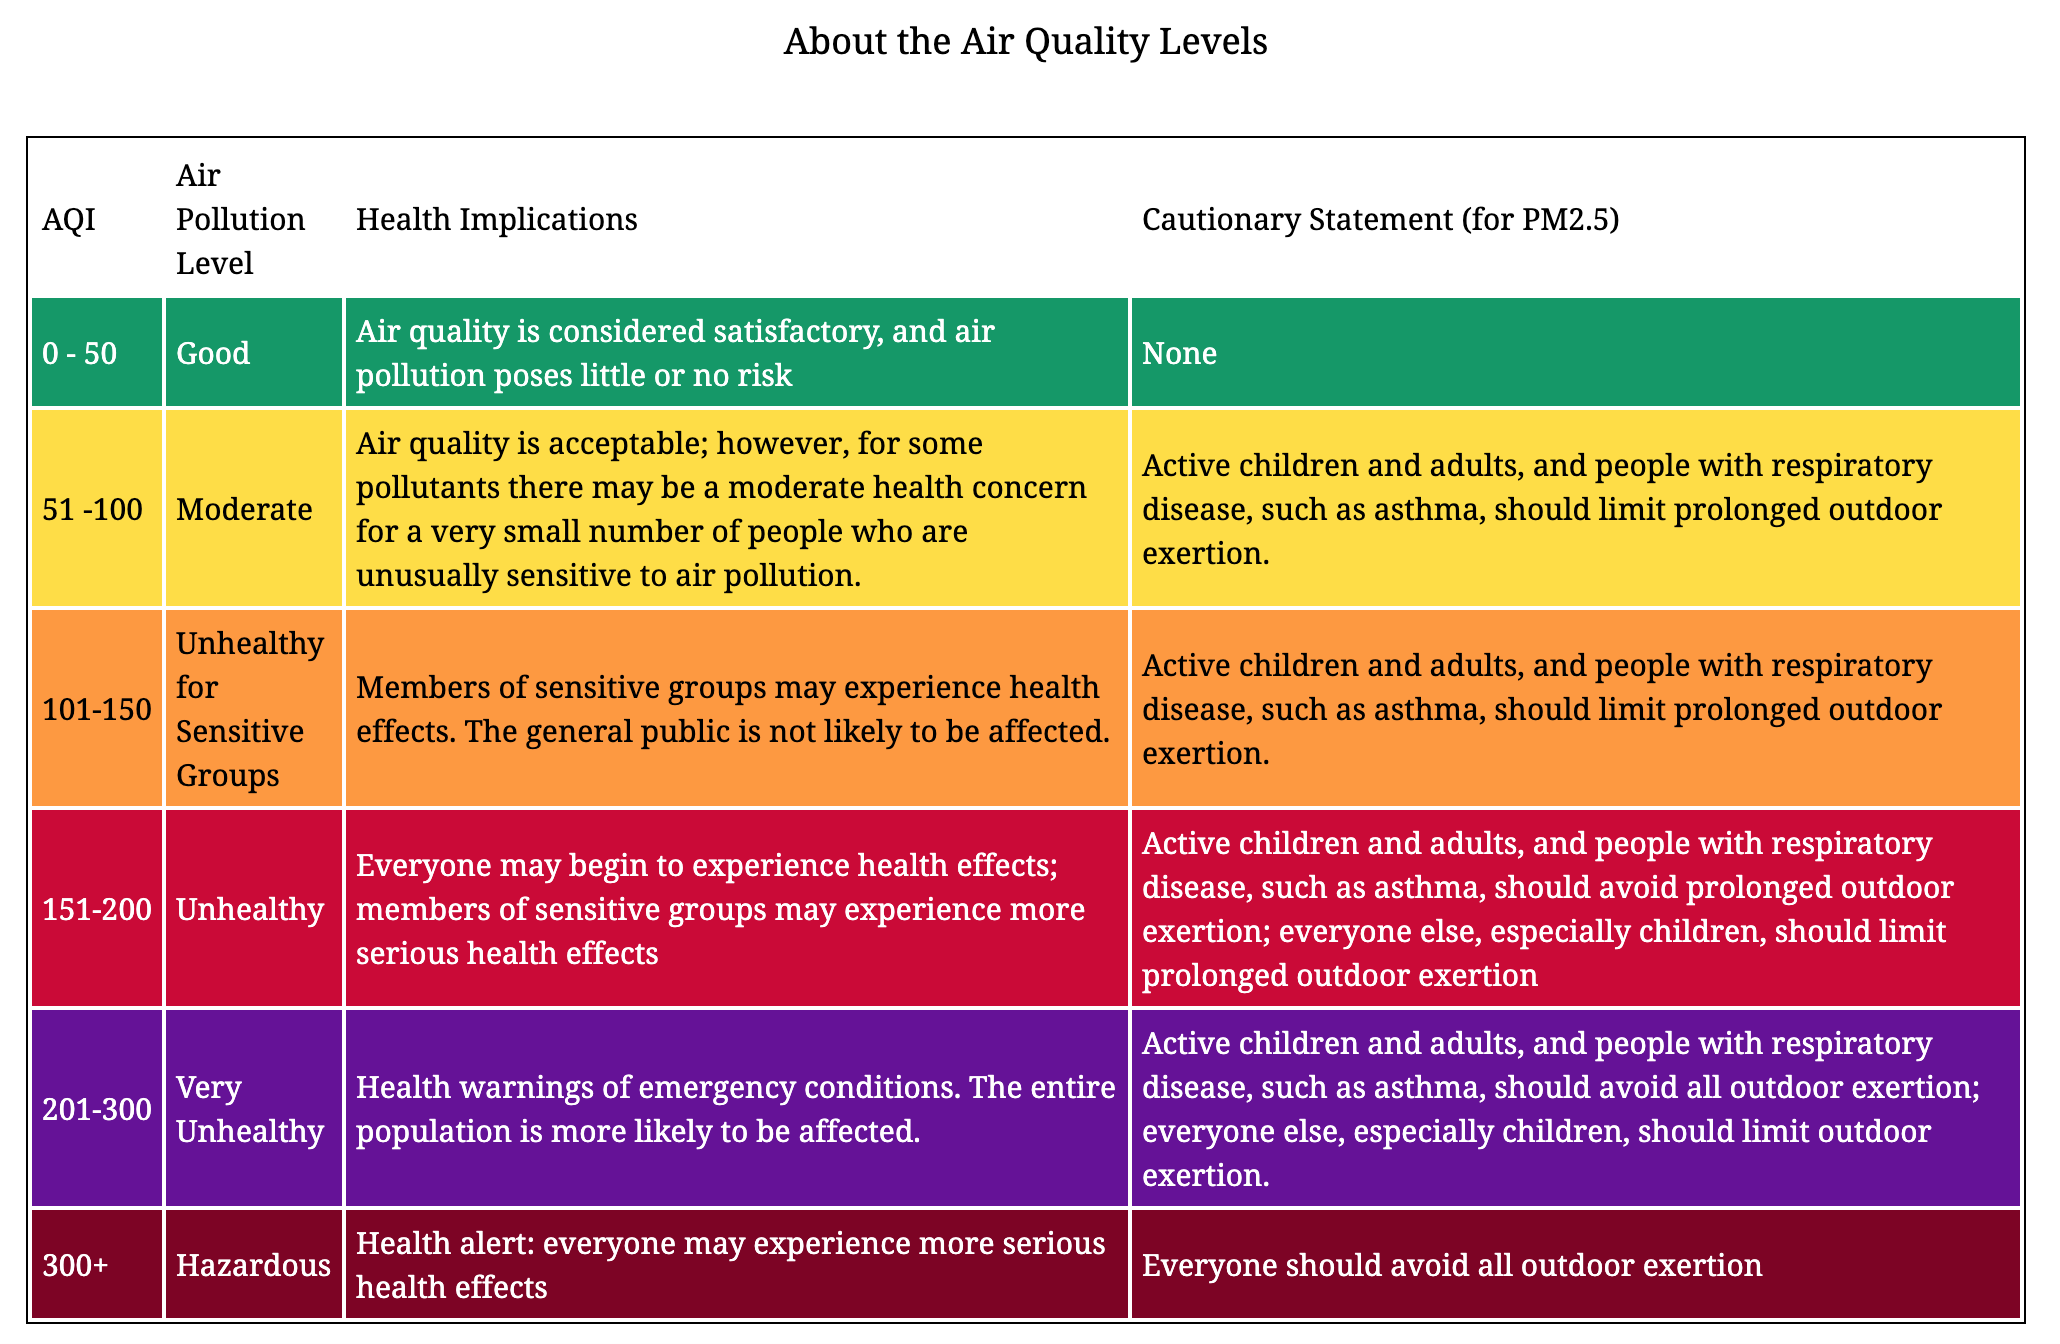

In [20]:
i = Image.open("../input/geo-bud-districts/Description of AQI levels.png")
i

## 3. TimeSliderChoropleth to show the change of the AQI over the years

In this section we are going to create a choropleth map with a timeslider. It will let us examine how the AQI value was changing (almost) every day during 2016-2019 in every district.

A good example of creating this type of map can be found [here](https://github.com/python-visualization/folium/blob/master/examples/TimeSliderChoropleth.ipynb).

Using both color and opacity gives us the ability to simultaneously visualize two features on the choropleth. Color can be used to visualize the main feature and opacity to visualize how many measurements were in that group. In our case we only have 1 feature - the AQI value. Still, the use of opacity in the style dictionary is obligatory! We will simply set it to a fixed value.

In [21]:
daily_AQI = unstacked_AQI.groupby(["station_in_district","date"]).max()

# Log transform AQI index values to show the differences in time more clearly
daily_AQI = np.log(daily_AQI)

In [22]:
daily_AQI.index = daily_AQI.index.set_levels((pd.to_datetime(daily_AQI.index.levels[1])
                 .astype(int) // 10**9)
                 .astype('U10'), level=1)
daily_AQI.head()

station_in_district  date      
station_in_I         1577491200    2.833213
                     1577404800    2.484907
                     1577318400    2.564949
                     1577232000    2.639057
                     1577145600    2.639057
dtype: float64

We want to map the column with the AQI index to a hex color. To do this we use a normal colormap. To create the colormap, we calculate the maximum and minimum values over all the timeseries.

In [23]:
max_AQI = daily_AQI.max()
max_AQI

5.537334267018537

In [24]:
min_AQI = daily_AQI.min()
min_AQI

1.9459101490553132

Define and apply maps:

In [25]:
from branca.colormap import linear

# abot color brewer
cmap = linear.YlOrRd_09.scale(min_AQI, max_AQI)
daily_AQI = daily_AQI.apply(cmap)

In [26]:
daily_AQI_df = pd.DataFrame(daily_AQI, columns=['color'])
daily_AQI_df.reset_index(level='date',inplace=True)
daily_AQI_df.head()

date      color
station_in_district                       
station_in_I         1577491200  #ffda77ff
station_in_I         1577404800  #ffe998ff
station_in_I         1577318400  #ffe690ff
station_in_I         1577232000  #ffe389ff
station_in_I         1577145600  #ffe389ff

We create a separate dataframe with the district_id and the closest to it station:

In [27]:
closest_stations = pd.DataFrame(gdf_districts[['closest_station','district_code']]).reset_index(drop=False)
closest_stations.head()

district_id  closest_station  district_code
0    district_I     station_in_I            1.0
1   district_II    station_in_II            2.0
2  district_III  station_in_XIII            3.0
3   district_IV    station_in_IV            4.0
4    district_V     station_in_I            5.0

We will now merge the closest_stations and daily_AQI_df to create the style_df that will show specific color for a specific date and district based on the AQI value on that day.

In [28]:
style_df = closest_stations.merge(daily_AQI_df[['date','color']], left_on='closest_station', right_on='station_in_district')
style_df.drop('closest_station', axis=1, inplace=True)
style_df.head()

district_id  district_code        date      color
0  district_I            1.0  1577491200  #ffda77ff
1  district_I            1.0  1577404800  #ffe998ff
2  district_I            1.0  1577318400  #ffe690ff
3  district_I            1.0  1577232000  #ffe389ff
4  district_I            1.0  1577145600  #ffe389ff

Next we create a dictionary (style_dict) that has all the necessary information structured in a specific way. Here we assign opacity = 1 to every row.

In [29]:
district_list = style_df['district_id'].unique().tolist()
district_idx = range(len(district_list))

style_dict = {}
for i in district_idx:
    district = district_list[i]
    result = style_df[style_df['district_id'] == district]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date']] = {'color': r['color'], 'opacity': 1}
    style_dict[str(i)] = inner_dict

Below is the geodataframe that is used to draw district borders on the map.

In [30]:
districts_df = gdf_districts[['geometry']]
districts_gdf = gdp.GeoDataFrame(districts_df)
districts_gdf = districts_gdf.drop_duplicates().reset_index()
districts_gdf.head()

district_id                                           geometry
0    district_I  POLYGON ((19.02378 47.49568, 19.02380 47.49619...
1   district_II  POLYGON ((18.92511 47.54414, 18.92919 47.54560...
2  district_III  POLYGON ((18.97684 47.57484, 18.97751 47.57575...
3   district_IV  POLYGON ((19.06720 47.56314, 19.06741 47.56360...
4    district_V  POLYGON ((19.04202 47.51471, 19.04332 47.51475...

Finally, we create a TimeSlider map.

Note: Zooming the Folium TimeSliderChoropleth is currently not working in Chrome, at the moment it's an open [issue](https://github.com/python-visualization/folium/issues/841).

In [31]:
# Initialize a map
m_time_slider_AQI = folium.Map([47.4857,19.0902], tiles='Stamen Toner', zoom_start=11,min_zoom=2, max_bounds=True)

# Draw a TimeSliderChoropleth on it
g = TimeSliderChoropleth(
    districts_gdf.to_json(),
    styledict=style_dict

).add_to(m_time_slider_AQI)

# Add a GeoJsonTooltip to the map to show district number when hovering the mouse over it
geojson1 = folium.GeoJson(data=districts.to_json(),
                          style_function=lambda x: {'color':'white','fillColor':'transparent','weight':0.5},
                          tooltip=folium.GeoJsonTooltip(fields=['district_code'],
                                                        labels=False,
                                                        sticky=True),
                          highlight_function=lambda x: {'weight':2,'fillColor':'grey'}
                        
            ).add_to(m_time_slider_AQI)

# Show the scale of values
_ = cmap.add_to(m_time_slider_AQI)
cmap.caption = "LOG Air Quality Index - the max median among 5 parameters over 2016-2019"

# Save and display the map
m_time_slider_AQI.save(outfile='timeslider_budapest_AQI_2016-2019.html')
m_time_slider_AQI

It is interesting to see how the air quality changes over time in Budapest. 

There is a slight regularity that I've noticed - in winter times the air quality is worse than at other times throught a year. 

It can be explained in a [following way](https://www.accuweather.com/en/health-wellness/why-air-pollution-is-worse-in-winter/689434#:~:text=The%20reason%20for%20this%20is,in%20the%20dense%20colder%20air.): "cold air is denser and has less space between the molecules of gas. When the temperature drops and cold air blankets the ground, any warm air is forced to pass over it. In this way, the cold air can form a kind of cap. Pollutants aren’t as free to escape and disperse in the dense colder air. This density means that cold air traps the pollution but also doesn’t whisk it away. Air pollution in winter remains in place for much longer and therefore is breathed in at a higher rate than during the summer".

There are also quite a few dates when the air quality was much worse in particular districts but not in others. This should be inspected further to understand the reasons behind. Here are some examples of those dates for a possibe future research:
* Feb 22 2017 (20th,21st,22nd districts);
* Apr 04 2017 (4th district);
* Nov 30 2017 (20th,21st,22nd districts);
* Feb 17 2018 (4th district);
* Jun 06 2018 (13th, 14th districts);
* Aug 02 2018 (8th district);
* Sep 02 2018 (8th district);
* Nov 05 2018 (1st, 2nd, 3rd districts);
* Dec 23 2018 (15th district);
* Mar 25 2019 (1st, 2nd, 3rd districts);
* Oct 03 2019 (9th, 10th, 11th, 12th districts).

## 4. Displaying 5 parameters of the aggregate AQI using feature group and layer control

In [32]:
median_AQI_per_param.head()

station_in_district  parameter
station_in_I          co           5.0
                     no2          19.0
                     o3           13.0
                     pm10         29.0
                     so2           2.0
dtype: float64

In [33]:
fg_df = median_AQI_per_param.reset_index()
fg_df.columns = ['station_in_district','parameter','value']

fg_df = closest_stations.merge(fg_df[['station_in_district','parameter','value']], left_on='closest_station', right_on='station_in_district')
fg_df.drop(['closest_station','station_in_district'], axis=1, inplace=True)

fg_df.set_index(['district_id'], inplace=True)

fg_df.head()

district_code parameter  value
district_id                                
district_I             1.0        co    5.0
district_I             1.0       no2   19.0
district_I             1.0        o3   13.0
district_I             1.0      pm10   29.0
district_I             1.0       so2    2.0

Create separate dataframes for each parameter:

In [34]:
co = fg_df[fg_df['parameter'] == ' co']
no2 = fg_df[fg_df['parameter'] == 'no2']
o3 = fg_df[fg_df['parameter'] == 'o3']
pm10 = fg_df[fg_df['parameter'] == 'pm10']
so2 = fg_df[fg_df['parameter'] == 'so2']

In [35]:
# Initialize a map
m_parameters = folium.Map([47.4857,19.0902], tiles='cartodbpositron', zoom_start=11,min_zoom=2, max_bounds=True)

# Create feature groups
feature_group0 = folium.FeatureGroup(name='co',overlay=True).add_to(m_parameters)
feature_group1= folium.FeatureGroup(name='no2',overlay=True).add_to(m_parameters)
feature_group2 = folium.FeatureGroup(name='o3',overlay=True).add_to(m_parameters)
feature_group3= folium.FeatureGroup(name='pm10',overlay=True).add_to(m_parameters)
feature_group4 = folium.FeatureGroup(name='so2',overlay=True).add_to(m_parameters)

fs = [feature_group0,feature_group1,feature_group2,feature_group3,feature_group4]
parameters = [co.value,no2.value,o3.value,pm10.value,so2.value]

# Add a choropleth map for each parameter
for i in range(len(parameters)): 
    choropleth1 = folium.Choropleth(
    geo_data=districts.to_json(),
    name='choropleth',
    data=parameters[i],
    key_on='feature.id',
    fill_color='YlGn',
    nan_fill_color="black",
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True,
    line_color='black').geojson.add_to(fs[i])

# Add a GeoJsonTooltip to the map to show district number when hovering the mouse over it
geojson1 = folium.GeoJson(data=districts.to_json(),
                          style_function=lambda x: {'color':'green','fillColor':'transparent','weight':0.5},
                          tooltip=folium.GeoJsonTooltip(fields=['district_code'],
                                                        labels=False,
                                                        sticky=True),
                          highlight_function=lambda x: {'weight':2,'fillColor':'grey'},
                        
                         ).add_to(choropleth1)
    
# Show the scale of values
colormap = linear.YlGn_09.scale(
fg_df.value.min(),
fg_df.value.max()).to_step(10)
colormap.caption = 'Median AQI for each parameter over 2016-2019'
colormap.add_to(m_parameters)
   
# Add layer control tool that lets you choose how many parameters to show on the map
folium.LayerControl(collapsed=False).add_to(m_parameters)

# Save and display the map
m_parameters.save('median_AQI_per_parameter.html')
m_parameters

The above map can be used to investigate the influence of specific parameters (components of an aggregate AQI) and their combinations on the air quality in Budapest. 

- "co" is quite high in most of the districts but highest in the 11th district;
- "no2" is mostly elevated in the districts 11, 12, 1, 5, 9, 8, 7, 14;
- "o3" level is the highest in the 2nd district;
- "pm10" is worst in the districts 1, 5, 12;
- "so2" is the highest in the 11th district.

## Conclusion

In this notebook I have conducted a reseach of the Air Quality in Budapest using Folium, a library that makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map.

The district borders data was extracted using the geocoding technique through the OSMNX library. The air quality data is collected manually from the aqicn.org website.

We have used data from 11 measuring stations in Budapest while there are 23 districts. To resolve this issue, we found the closest station to the center of each district using the centroid of each polygon (a POINT object with longitude and latitude coordinates).

Then we have calculated the median Air Quality Index value over the years 2016-2019 for each district based on the maximum among 5 measured parameters (co, no2, o3, pm10, so2).

Based on that index we have discovered that the best air quality is in the 6th, 13th, 11th and 3rd districts. The worst air quality is in the 2nd, 12th, 1st and 5th districts. The difference between the best and the worst districts is not enormous - it ranges from 19 to 30.

The overall air pollution level in Budapest can be described as "Good", meaning that air quality is considered satisfactory, and air pollution poses little or no risk.

In the next section we have created a choropleth map with a timeslider which lets us examine how the AQI value was changing during 2016-2019 in every district.

We have noticed a slight regularity - in winter times the air quality is worse than at other times throught a year. It can be explained by the fact that the cold air is more dense, so it doesn't let pollutants escape that easily as the warm air.

There are also quite a few dates when the air quality was much worse in particular districts but not in others. This should be inspected further for each date to understand the reasons behind (for example reading the news around that date).

Finally, we have investigated the influence of specific parameters (components of an aggregate AQI) on the air quality in Budapest using feature group and layer control functionalities and found that:

- "co" is quite high in most of the districts but highest in the 11th district;
- "no2" is mostly elevated in the districts 11, 12, 1, 5, 9, 8, 7, 14;
- "o3" level is the highest in the 2nd district;
- "pm10" is worst in the districts 1, 5, 12;
- "so2" is the highest in the 11th district.